# Ensemble point distributions

This example uses some helper classes in the InteractivePlot module. The module's aim is to provide a simpler way of building interactive displays with matplotlib and nbagg. You can find the code under /libs; it's not very long, or official.

We'll be using mogreps data for relative humidity. Our goal in this example is to make a map you can click on to show the distribution of ensemble members for that point.

In [1]:
# !conda install boto3 -y

In [2]:
import iris
import boto3
import numpy as np
import pickle
import tempfile
import iris.plot as iplt
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython import display
from libs import InteractivePlot as inpl

Using matplotlib in nbagg mode lets us update plots on the fly.

In [3]:
%matplotlib nbagg

This just loads some canned data from an S3 bucket and unpickles it. We'll end up with an iris cube.

In [4]:
client = boto3.client('s3')
temp = tempfile.NamedTemporaryFile()
client.download_file('mogreps-pickles', 'demo_mogreps', temp.name)
with open(temp.name, 'rb') as pickle_file:
    cube = pickle.load(pickle_file)

In [5]:
cube

<iris 'Cube' of relative_humidity / (%) (realization: 33; latitude: 100; longitude: 66)>

First, we'll make some functionality for our main map. Here's a plotting function to draw the map, with a title and colour bar.

In [6]:
def draw_map_hook(cube):
    iplt.pcolormesh(cube, cmap="viridis")
    plt.gca().coastlines()
    plt.title("relative humidity")
    cbar = plt.colorbar(orientation="horizontal")
    labs = cbar.ax.xaxis.get_majorticklabels()
    cbar.ax.xaxis.set_ticklabels(labs,rotation=45)

Now we'll make our interactive plot, telling it to use our plotting function.

<IPython.core.display.Javascript object>


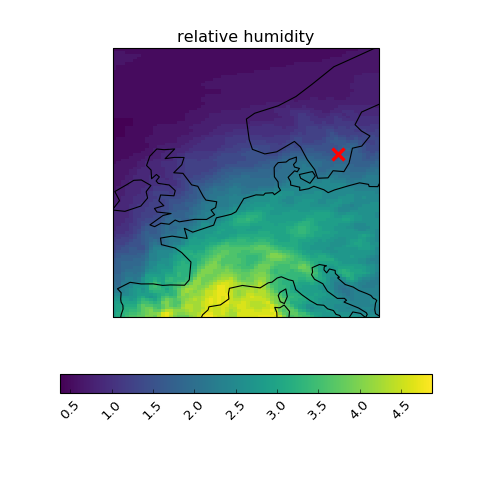

/opt/conda/envs/py34/lib/python3.4/site-packages/iris/coords.py:802: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/opt/conda/envs/py34/lib/python3.4/site-packages/iris/coords.py:802: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


In [7]:
main_plot = inpl.InteractivePlot(cube, draw_map_hook, figsize=(6,6))
main_plot.plot()

Right now, our map isn't interactive at all. Let's add a slider to move between realizations. We'll use the ipywidgets module.

In [8]:
def on_value_change(a):
    main_plot.update_slice((a['new'], slice(None), slice(None)))

pslider = widgets.IntSlider(value=0, 
                            min=0, 
                            max=cube.coord('realization').shape[0],
                            description='realization')
display.display(pslider)

pslider.observe(on_value_change, names='value')

/opt/conda/envs/py34/lib/python3.4/site-packages/iris/coords.py:802: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/opt/conda/envs/py34/lib/python3.4/site-packages/iris/coords.py:802: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/opt/conda/envs/py34/lib/python3.4/site-packages/iris/coords.py:802: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/opt/conda/envs/py34/lib/python3.4/site-packages/iris/coords.py:802: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


The 'pslider.observe' line calls the 'on_value_change' function every time the slider moves. In turn, the 'on_value_change' function updates our main plot to display a new slice. It uses the new slider position as the realization value, and says to display all latitudes and longitudes by setting them to 'slice(None)'.

If the slice stuff seems unintuitive, don't panic. That's the only place we'll need to use it directly.

We'd also like our map to be clickable. We'll first add a function which draws an 'x' wherever the map is clicked.

In [9]:
def on_map_click(obj, event):
    # draw an x
    plt.plot(event.xdata, event.ydata, 'xr', ms=10, mew=3)

main_plot.add_event_listener('button_press_event', on_map_click)

Now we'll add some extra graphs, to show the distribution at a point. This function takes a cube with one (realization) dimension and draws a histogram.

In [10]:
def draw_hist_hook(cube):
    plt.xticks(rotation=45)
    plt.hist(cube.data)
    ax = plt.gca()
    ax.set_ylim(bottom=0)
    ax.set_xlabel('relative humidity')
    ax.set_ylabel('realizations')
    plt.tight_layout()

We'll initialize a subplot using this function, and update it each time there's a button press on the main map.

<IPython.core.display.Javascript object>


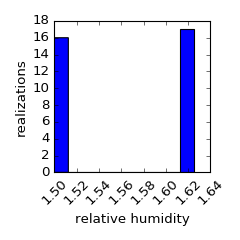

8

In [11]:
s1 = inpl.Subplot(draw_hist_hook, figsize=(3,3))
def update_s1(event):
    cube = main_plot.get_event_cube(event)
    s1.plot(cube)

main_plot.fig.canvas.mpl_connect('button_press_event', update_s1)

Finally, we'll add a second subplot which shows the realizations as a scatter plot.

<IPython.core.display.Javascript object>


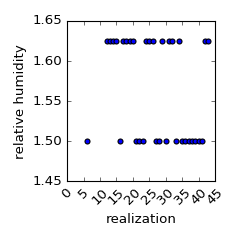

9

In [13]:
def realization_hook(cube):
    plt.xticks(rotation=45)
    plt.scatter(cube.coord('realization').points, cube.data)
    ax = plt.gca()
    ax.set_xlabel('realization')
    ax.set_ylabel('relative humidity')
    plt.tight_layout()
    
s2 = inpl.Subplot(realization_hook, figsize=(3,3))
def update_s2(event):
    cube = main_plot.get_event_cube(event)
    s2.plot(cube)

main_plot.fig.canvas.mpl_connect('button_press_event', update_s2)

Now open the dashboard view to see the plots interacting.